# 🧠 Feature Engineering
This notebook performs feature engineering on the fraud detection dataset.
It includes behavioral flags, balance comparisons, time-based features, and derived ratios.

In [16]:
# 📥 Load Data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('onlinefraud.csv') 
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 🔧 Step 1: Balance Difference Features
- Measures how much was deducted from the sender and added to the receiver.
- Helps detect if the transaction flow is consistent.

In [17]:
df['balance_diff_org'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

## 🧮 Step 2: Amount Consistency Checks
- Compares transaction amount to changes in balances.
- Highlights unusual behavior when the balance doesn't reflect the transaction amount.

In [18]:
df['amount_diff_org'] = df['amount'] - df['balance_diff_org']
df['amount_diff_dest'] = df['amount'] - df['balance_diff_dest']

## 📊 Step 3: Proportional Transaction Feature
- Ratio of transaction amount to the sender’s original balance.
- Indicates how large the transaction is relative to their capacity — higher ratios are more suspicious.

In [19]:
df['txn_ratio'] = df.apply(lambda x: x['amount'] / x['oldbalanceOrg'] if x['oldbalanceOrg'] > 0 else 0, axis=1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_diff_org,balance_diff_dest,amount_diff_org,amount_diff_dest,txn_ratio
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0,-1.455192e-11,9839.64,0.057834
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0,1.136868e-12,1864.28,0.087735
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0,0.000000e+00,181.00,1.000000
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0,0.000000e+00,21363.00,1.000000
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0,0.000000e+00,11668.14,0.280795


## 🚩 Step 4: Binary Flags for Suspicious Behavior
- `is_sender_zero_bal`: Sender had 0 balance before and after transaction.
- `is_receiver_zero_before`: Receiver had 0 before transaction — drop account alert.
- `is_receiver_exact_amount`: Receiver balance increased by exactly the amount — mule pattern.
- `is_large_txn`: Flags transactions above a certain threshold (e.g., >200,000).
- `org_to_dest_same`: Same sender and receiver — potential fake or test transaction.


In [20]:
df['is_sender_zero_bal'] = ((df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0)).astype(int)
df['is_receiver_zero_before'] = (df['oldbalanceDest'] == 0).astype(int)
df['is_receiver_exact_amount'] = (df['balance_diff_dest'] == df['amount']).astype(int)
df['is_large_txn'] = (df['amount'] > 200000).astype(int)
df['org_to_dest_same'] = (df['nameOrig'] == df['nameDest']).astype(int)

## 👥 Step 5: User Type Indicators
- `sender_is_customer`, `receiver_is_customer`, `receiver_is_merchant`: Based on ID prefixes (`C` for customer, `M` for merchant).

In [21]:
df['sender_is_customer'] = df['nameOrig'].str.startswith('C').astype(int)
df['receiver_is_customer'] = df['nameDest'].str.startswith('C').astype(int)
df['receiver_is_merchant'] = df['nameDest'].str.startswith('M').astype(int)

## ⚠️ Step 6: High-Risk Combo Feature
- `risk_combo`: Combines high-value transaction with zero balances and drop account behavior.
- Helps capture complex fraud logic in a single binary feature.

In [22]:
df['risk_combo'] = df['is_large_txn'] * df['is_sender_zero_bal'] * df['is_receiver_zero_before']

## ⏰ Step 7: Time-Based Features
- `hour`: Extracted from `step % 24` assuming hourly intervals.
- `is_night`: Flags transactions happening between midnight and 6 AM — unusual hours for regular activity.

In [23]:
df.head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,txn_ratio,is_sender_zero_bal,is_receiver_zero_before,is_receiver_exact_amount,is_large_txn,org_to_dest_same,sender_is_customer,receiver_is_customer,receiver_is_merchant,risk_combo
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,...,0.057834,0,1,0,0,0,1,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,...,0.087735,0,1,0,0,0,1,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,...,1.000000,0,1,0,0,0,1,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,...,1.000000,0,0,0,0,0,1,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,...,0.280795,0,1,0,0,0,1,0,1,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,...,0.145149,0,1,0,0,0,1,0,1,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,...,0.038799,0,1,0,0,0,1,0,1,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,...,0.044646,0,1,0,0,0,1,0,1,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,...,1.506687,0,1,0,0,0,1,0,1,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,...,0.127943,0,0,0,0,0,1,1,0,0


In [24]:
df['hour'] = df['step'] % 24
df['is_night'] = df['hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)

In [29]:
#label categotical columns
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df['type'] = label.fit_transform(df['type'])


df.head(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,is_receiver_zero_before,is_receiver_exact_amount,is_large_txn,org_to_dest_same,sender_is_customer,receiver_is_customer,receiver_is_merchant,risk_combo,hour,is_night
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,...,1,0,0,0,1,1,0,0,1,1
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,...,0,0,0,0,1,1,0,0,1,1
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
5,1,3,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
6,1,3,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
7,1,3,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
8,1,3,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,...,1,0,0,0,1,0,1,0,1,1
9,1,2,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,...,0,0,0,0,1,1,0,0,1,1


## 🔍 Step 8: Correlation Heatmap

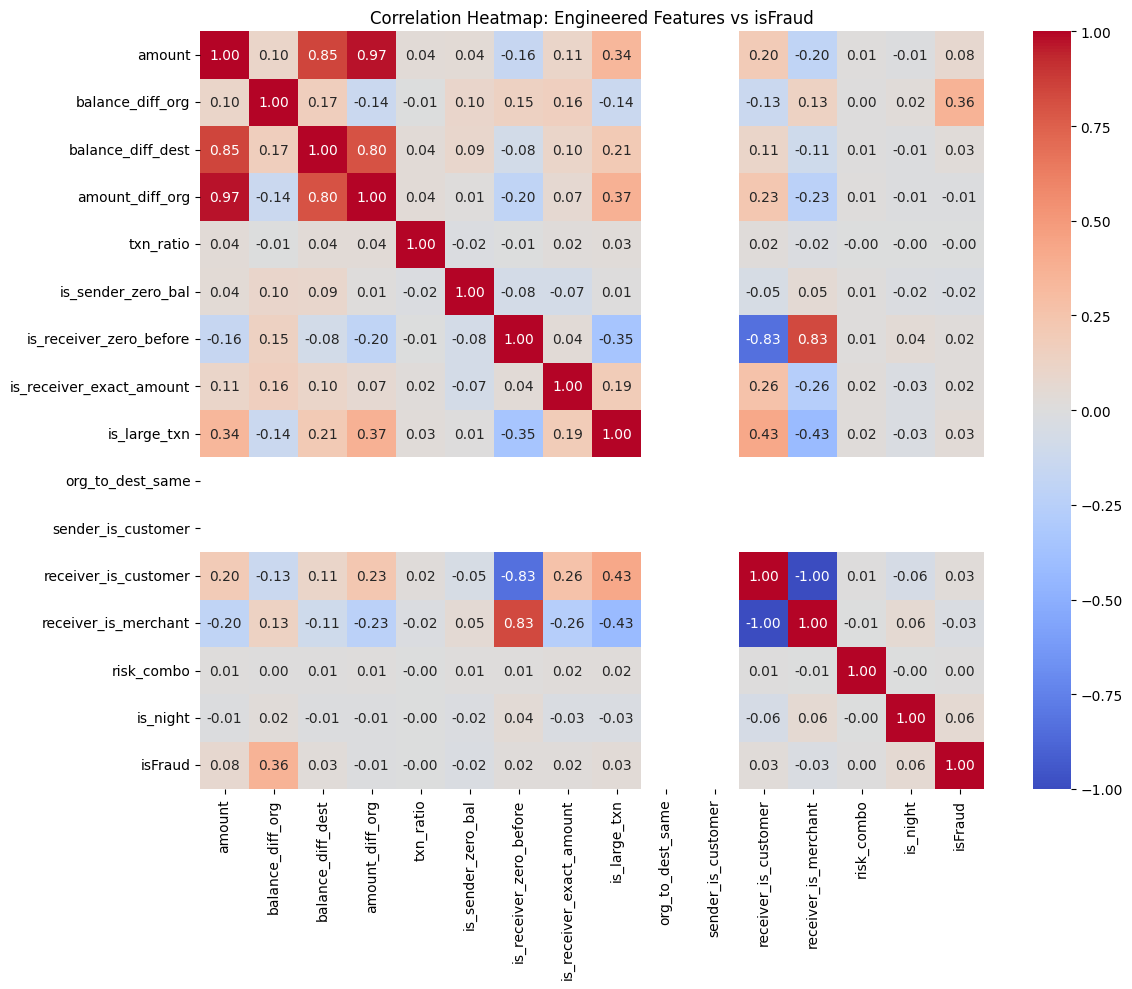

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_check = [
    'amount', 'balance_diff_org', 'balance_diff_dest', 'amount_diff_org', 'txn_ratio',
    'is_sender_zero_bal', 'is_receiver_zero_before', 'is_receiver_exact_amount',
    'is_large_txn', 'org_to_dest_same', 'sender_is_customer', 'receiver_is_customer',
    'receiver_is_merchant', 'risk_combo', 'is_night', 'isFraud'
]

plt.figure(figsize=(12, 10))
sns.heatmap(df[features_to_check].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Engineered Features vs isFraud")
plt.tight_layout()
plt.show()

## 💾 Step 9: Save Enhanced Dataset

In [30]:
df.to_csv('enhanced_online_fraud_dataset.csv', index=False)
print('✅ Dataset saved as enhanced_online_fraud_dataset.csv')

✅ Dataset saved as enhanced_online_fraud_dataset.csv
